# Run Log Charts

Notebook to develop chart based on daily run log

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import boto3

## Read in data

In [2]:
cd ~/Downloads/

C:\Users\jerem\Downloads


In [3]:
pwd

'C:\\Users\\jerem\\Downloads'

In [4]:
# Read in from local
# raw_data_df = pd.read_csv('Workout log - DailyRunLog.csv')

# Read in data from s3
bucket = "jeremyruns.com"
file_name = "daily_run_log.csv"

s3 = boto3.client('s3') 
obj = s3.get_object(Bucket= bucket, Key= file_name) 
raw_data_df = pd.read_csv(obj['Body'])

print(f'Records read in: {raw_data_df.shape[0]}')
#raw_data_df.dtypes

### Prep data, create rolling average variables

In [7]:
df = raw_data_df.copy()

In [8]:
# Make Date a datetime object
df['Date'] = pd.to_datetime(df["Date"])

# Fill missing miles with 0
df['Miles'].fillna(0, inplace=True)

# Create rolling averages
df['MA_5day'] = df['Miles'].rolling(window=5).mean()
df['MA_10day'] = df['Miles'].rolling(window=10).mean()
df['MA_30day'] = df['Miles'].rolling(window=30).mean()

df = df.sort_values('Date')

In [9]:
def preprocess_raw_df(df_) -> pd.DataFrame:
    """ Function to preprocess raw daily data """
    df_ = (df_
           .assign(Date=pd.to_datetime(df_["Date"]))  # Make Date a datetime object
           .assign(Miles=lambda x: df_['Miles'].fillna(0))  # Fill missing miles with 0
           .assign(MA_10day=df_['Miles'].rolling(window=10).mean())  # Create rolling averages
           .assign(MA_30day=df_['Miles'].rolling(window=30).mean())
           .sort_values('Date')
          )
    return df_

In [10]:
df = df.pipe(preprocess_raw_df)

In [11]:
# Remove days in future
df = df[df['Date']<datetime.datetime.today()]

In [12]:
days_of_data = df.shape[0]
print(f'Days of data: {days_of_data}')
print(f'Years of data: {round(days_of_data/365.0,2)}')

total_miles_run = df["Miles"].sum()
print(f'Total miles run: {total_miles_run}')

Days of data: 3286
Years of data: 9.0
Total miles run: 4881.6


## Plot data

In [13]:
# daily miles all time

# sns.set(rc = {'figure.figsize':(15,8)})
# sns.lineplot(x = 'Date', y = 'Miles',data = df)
# sns.scatterplot(x = 'Date', y = 'Miles',data = df, color='orange')
# plt.title('All tracked runs')

C:\Users\jerem\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


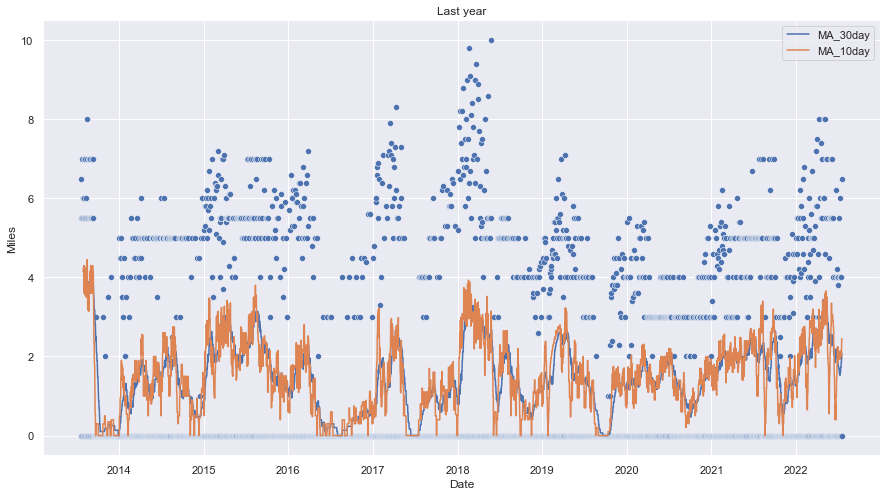

In [14]:
# Last 365 days- 10, 30 day MA
sns.set(rc = {'figure.figsize':(15,8)})
sns.scatterplot(data = df.tail(3650), x = "Date", y = "Miles")
sns.lineplot('Date', 'value', hue='variable', 
             data=pd.melt(df.tail(3650)[['Date', 'MA_30day', 'MA_10day']], 'Date'))
plt.title('Last year')
plt.legend(['MA_30day', 'MA_10day'])
plt.savefig('last_year.png')

C:\Users\jerem\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


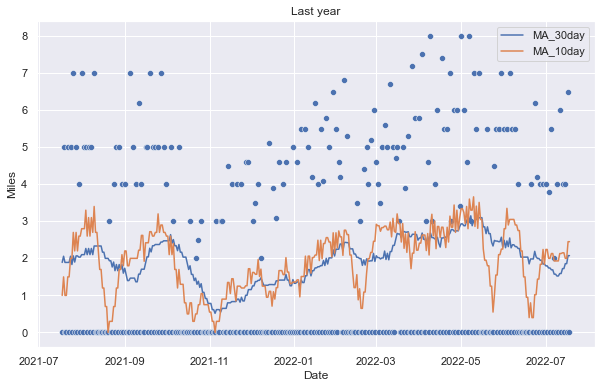

In [15]:
# Last 365 days- 10, 30 day MA
sns.set(rc = {'figure.figsize':(10,6)})
sns.scatterplot(data = df.tail(366), x = "Date", y = "Miles")
sns.lineplot('Date', 'value', hue='variable', 
             data=pd.melt(df.tail(366)[['Date', 'MA_30day', 'MA_10day']], 'Date'))
plt.title('Last year')
plt.legend(['MA_30day', 'MA_10day'])
plt.savefig('last_year.png')

In [16]:
def create_MA_over_time_chart(df, num_days_back):
    """ Function to create and save chart of MA over past num_days_back from df """
    sns.set(rc = {'figure.figsize':(15,10)})
    sns.scatterplot(data = df.tail(num_days_back), x = "Date", y = "Miles")
    sns.lineplot(x='Date', y='value', hue='variable', 
                 data=pd.melt(df.tail(num_days_back)[['Date', 'MA_30day', 'MA_10day']], 'Date'))
    plt.title(f'Last {num_days_back} days')
    plt.legend(['MA_30day', 'MA_10day'])
    plt.savefig(f'last_{num_days_back}_days_MA_over_time.png')

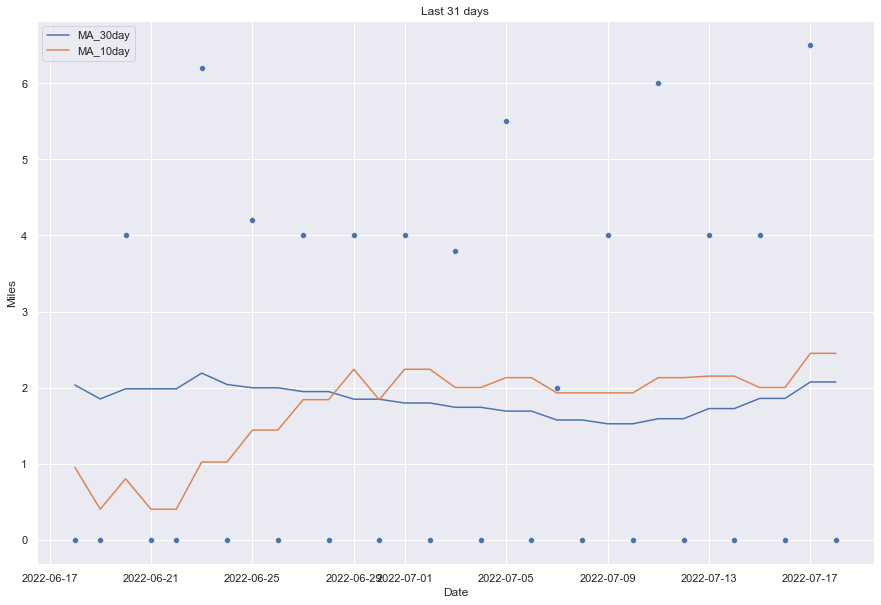

In [17]:
create_MA_over_time_chart(df=df, num_days_back=31)

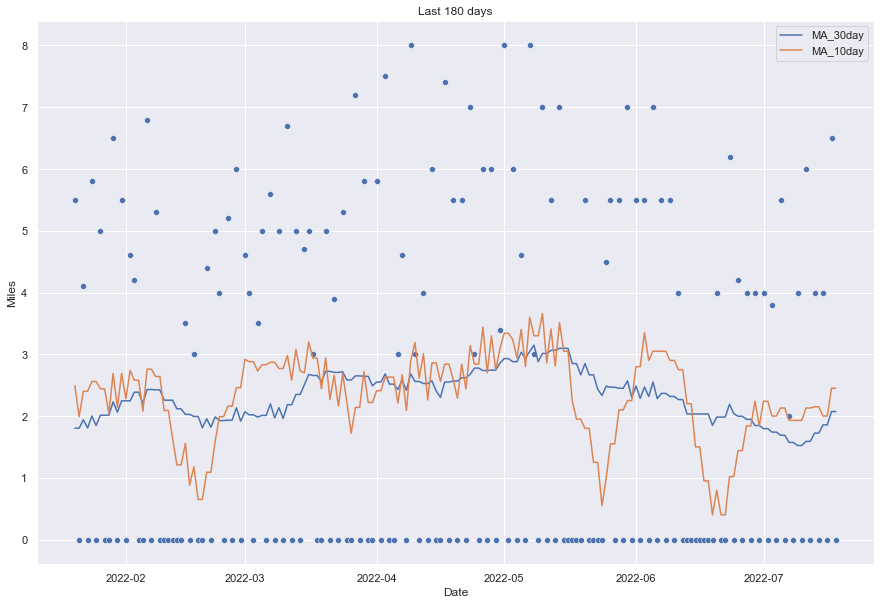

In [18]:
create_MA_over_time_chart(df=df, num_days_back=180)

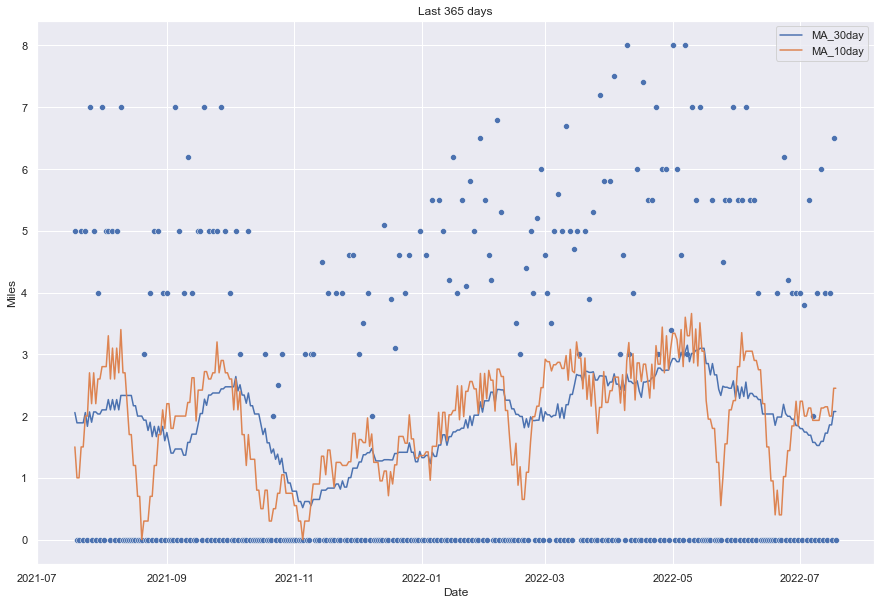

In [19]:
create_MA_over_time_chart(df=df, num_days_back=365)

### Calculate stats

In [19]:
def calc_runstats(df: pd.DataFrame, num_days_back):
    """
    
    Function to calculate stats from daily running dataframe
    
    :input: df: pd.DataFrame
    :return: dict
    """
    runstats_output = {}
    runstats_output['num_days_back'] = num_days_back
    num_days_run = sum(df.tail(num_days_back)['Miles']>0)
    runstats_output['num_days_run'] = num_days_run
    runstats_output['pct_days_run'] = round(100.0*num_days_run/num_days_back,1)
    tot_miles_run = round(df.tail(num_days_back)['Miles'].sum(),1)
    runstats_output['tot_miles_run'] = tot_miles_run
    runstats_output['miles_per_day'] = round(tot_miles_run/num_days_back,2)
    runstats_output['miles_per_run'] = round(tot_miles_run/num_days_run,2)
    return runstats_output

In [20]:
last_30_stats_dict = calc_runstats(df=df, num_days_back=30)
last_30_stats_dict

{'num_days_back': 30,
 'num_days_run': 12,
 'pct_days_run': 40.0,
 'tot_miles_run': 51.7,
 'miles_per_day': 1.72,
 'miles_per_run': 4.31}

In [21]:
last_30_text = f"""Last {last_30_stats_dict['num_days_back']} days: {last_30_stats_dict['num_days_run']} runs, \
{last_30_stats_dict['pct_days_run']}% of days, \
{last_30_stats_dict['tot_miles_run']} miles, \
{last_30_stats_dict['miles_per_day']} miles/day, \
{last_30_stats_dict['miles_per_run']} miles/run \
"""

print(last_30_text)

Last 30 days: 12 runs, 40.0% of days, 51.7 miles, 1.72 miles/day, 4.31 miles/run 


In [22]:
def create_metrics_text_from_dict(metrics_dict):
    """
    Function to create text string from metrics dict
    """
    
    metrics_text_string = f"""Last {metrics_dict['num_days_back']} days: \
{metrics_dict['num_days_run']} runs, \
{metrics_dict['pct_days_run']}% of days, \
{metrics_dict['tot_miles_run']} miles, \
{metrics_dict['miles_per_day']} miles/day, \
{metrics_dict['miles_per_run']} miles/run\
"""
    
    return metrics_text_string

In [23]:
last_90_text = create_metrics_text_from_dict(calc_runstats(df=df, num_days_back=90))
print(last_90_text)

Last 90 days: 38 runs, 42.2% of days, 198.2 miles, 2.2 miles/day, 5.22 miles/run


In [24]:
calc_runstats(df=df, num_days_back=90)

{'num_days_back': 90,
 'num_days_run': 38,
 'pct_days_run': 42.2,
 'tot_miles_run': 198.2,
 'miles_per_day': 2.2,
 'miles_per_run': 5.22}

In [25]:
last_180_text = create_metrics_text_from_dict(calc_runstats(df=df, num_days_back=180))
print(last_180_text)

Last 180 days: 80 runs, 44.4% of days, 411.2 miles, 2.28 miles/day, 5.14 miles/run


In [26]:
last_365_text = create_metrics_text_from_dict(calc_runstats(df=df, num_days_back=365))
print(last_365_text)

Last 365 days: 146 runs, 40.0% of days, 711.4 miles, 1.95 miles/day, 4.87 miles/run


In [27]:
all_data_text = create_metrics_text_from_dict(calc_runstats(df=df, num_days_back=df.shape[0]))
print(all_data_text)

Last 3285 days: 1014 runs, 30.9% of days, 4871.1 miles, 1.48 miles/day, 4.8 miles/run


In [28]:
# Previous month
calc_runstats(df=df.head((df.shape[0]-90)), num_days_back=90)

{'num_days_back': 90,
 'num_days_run': 42,
 'pct_days_run': 46.7,
 'tot_miles_run': 213.0,
 'miles_per_day': 2.37,
 'miles_per_run': 5.07}

In [29]:
# Current MA_10day
#curr_MA10day = round(df.tail(1)['MA_10day'].values[0],2)
#print(f' Current 10 day MA: {curr_MA10day}')

# Current MA_30day
#curr_MA30day = round(df.tail(1)['MA_30day'].values[0],2)
#print(f' Current 30 day MA: {curr_MA30day}')

In [30]:
# Last Month variables

# number of days run in last 10
#num_days_run_last10 = sum(df.tail(10)['Miles']>0)
#print(f'Days run in last 10: {num_days_run_last10}')

# number of days run in last month
#num_days_run_last30 = sum(df.tail(31)['Miles']>0)
#print(f'Days run in last 30: {num_days_run_last30}')

#avg_miles_per_run30 = round(df.tail(31)['Miles'].sum() / num_days_run_last30,2)
#print(f'Avg miles run in last 30: {avg_miles_per_run30}')

#miles_run30 = round(df.tail(31)['Miles'].sum(),2)
#print(miles_run30)

# number of days run in last 100 days
#sum(df.tail(100)['Miles']>0)

In [31]:
last_run_date

NameError: name 'last_run_date' is not defined

In [ ]:
pd.to_datetime(df[df['Miles']>0].tail(1)['Date'].values[0]).strftime('%A (%-m/%-d)')

In [32]:
# Last run
# df[df['Miles']>0].tail(1)

last_run_date = pd.Timestamp(df[df['Miles']>0].tail(1)['Date'].values[0])
last_run_distance = df[df['Miles']>0].tail(1)['Miles'].values[0]
#print(last_run_date)
last_run_notes = df[df['Miles']>0].tail(1)['Notes'].values[0]
#print(last_run_notes)

if pd.isnull(df[df['Miles']>0].tail(1)['Notes'].values[0]):
    last_run_text = f"Last Run: {last_run_date.strftime('(%m/%d)')} - {last_run_distance} miles"
else:
    last_run_text = f"Last Run: {last_run_date.strftime('(%m/%d)')} - {last_run_distance} miles ({last_run_notes})"

print(last_run_text)

Last Run: (07/13) - 4.0 miles


In [33]:
def create_last_run_text(df):
    """ Function to create text about the most recent run from df """
    last_run_date = pd.Timestamp(df[df['Miles']>0].tail(1)['Date'].values[0])
    last_run_distance = df[df['Miles']>0].tail(1)['Miles'].values[0]
    last_run_notes = df[df['Miles']>0].tail(1)['Notes'].values[0]

    if pd.isnull(df[df['Miles']>0].tail(1)['Notes'].values[0]):
        last_run_text = f"Last Run: {last_run_date.strftime('(%m/%d)')} - {last_run_distance} miles"
    else:
        last_run_text = f"Last Run: {last_run_date.strftime('(%m/%d)')} - {last_run_distance} miles ({last_run_notes})"

    return last_run_text

In [34]:
create_last_run_text(df)

'Last Run: (07/13) - 4.0 miles'

In [35]:
site_last_updated = datetime.datetime.now().strftime('(%m/%d)')
print(site_last_updated)

(07/17)


### Create html output for index

In [43]:
html_string = f"""

<html xmlns="http://www.w3.org/1999/xhtml" >
<head>
    <title>jeremyruns.com</title>
    <link rel="icon" type="image/png" src="s3://jeremyruns.com/favicon.png">
</head>
<body>
    <h1>Welcome to jeremyruns.com</h1>

    <h2>{last_run_text}</h2>
    
    Updated as of {site_last_updated}

    <h2>{last_30_text}</h2>
    <img src="https://s3.us-east-2.amazonaws.com/jeremyruns.com/last_31_days_MA_over_time.png">

    <h2>{last_180_text}</h2>
    <img src="https://s3.us-east-2.amazonaws.com/jeremyruns.com/last_180_days_MA_over_time.png">

    <h2>{last_365_text}</h2>
    <img src="https://s3.us-east-2.amazonaws.com/jeremyruns.com/last_365_days_MA_over_time.png">


    <h3>Total days of data tracked: {days_of_data}</h3>
    <h3>Total miles run: {total_miles_run}</h3>

</body>
</html>

"""

In [44]:
pwd

'C:\\Users\\jerem\\Downloads'

In [45]:
# Creating an HTML file
html_file = open("index.html","w")

# Adding input data to the HTML file
html_file.write(html_string)

# Saving the data into the HTML file
html_file.close()

### Write files to s3 bucket

In [ ]:
s3_client = boto3.resource('s3')
bucket = s3_client.Bucket('jeremyruns.com')

In [ ]:
# Upload index file
bucket.upload_file('index.html', 'index.html', ExtraArgs={'ContentType': 'text/html'})

In [ ]:
# Upload image files
bucket.upload_file('last_31_days_MA_over_time.png', 'last_31_days_MA_over_time.png', ExtraArgs={'ContentType': 'image/png'})

In [ ]:
bucket.upload_file('last_180_days_MA_over_time.png', 'last_180_days_MA_over_time.png', ExtraArgs={'ContentType': 'image/png'})

In [ ]:
bucket.upload_file('last_365_days_MA_over_time.png', 'last_365_days_MA_over_time.png', ExtraArgs={'ContentType': 'image/png'})